In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
paths = []
labels = []

for dir,_,file in os.walk("TESS Toronto emotional speech set data"):
    for fileName in file:
        paths.append(os.path.join(dir,fileName))
        label = (fileName.split("_")[-1]).split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
print()
print(paths[:5])
print()
print(labels[:5])


['TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav', 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav', 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav', 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav', 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

['angry', 'angry', 'angry', 'angry', 'angry']


In [4]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,TESS Toronto emotional speech set data\OAF_ang...,angry
1,TESS Toronto emotional speech set data\OAF_ang...,angry
2,TESS Toronto emotional speech set data\OAF_ang...,angry
3,TESS Toronto emotional speech set data\OAF_ang...,angry
4,TESS Toronto emotional speech set data\OAF_ang...,angry


In [5]:
df['label'].value_counts()

angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: label, dtype: int64

In [6]:
df['label'] = df['label'].replace('ps', 'surprised')
df['label'].value_counts()

angry        800
disgust      800
fear         800
happy        800
neutral      800
surprised    800
sad          800
Name: label, dtype: int64

In [7]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()

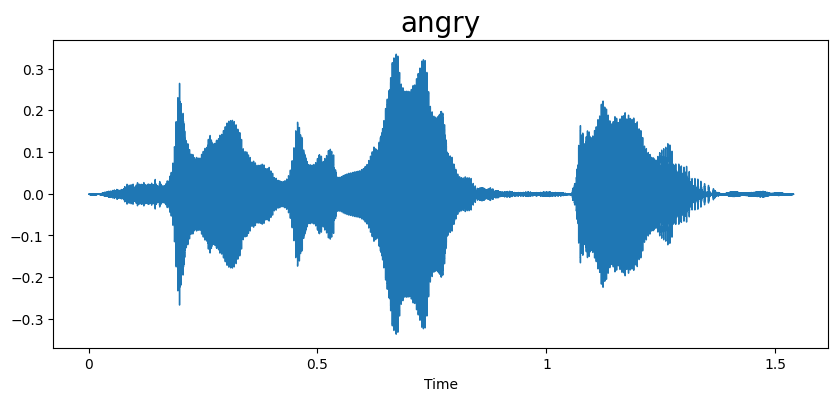

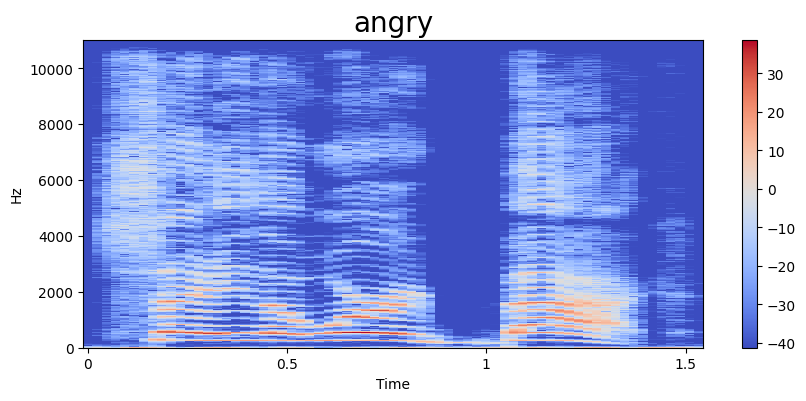

In [8]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

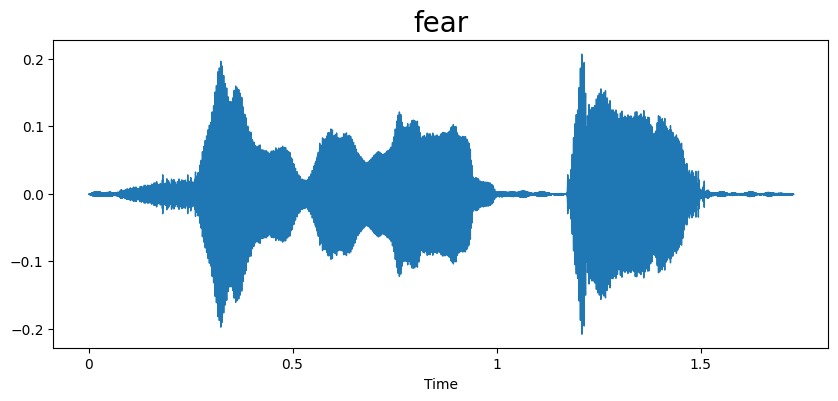

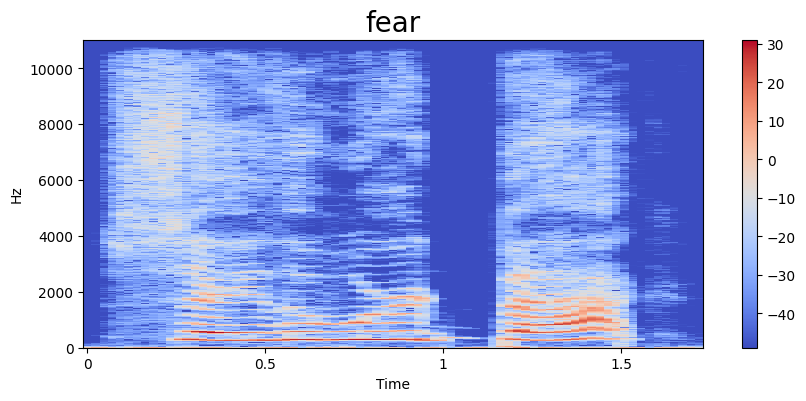

In [9]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

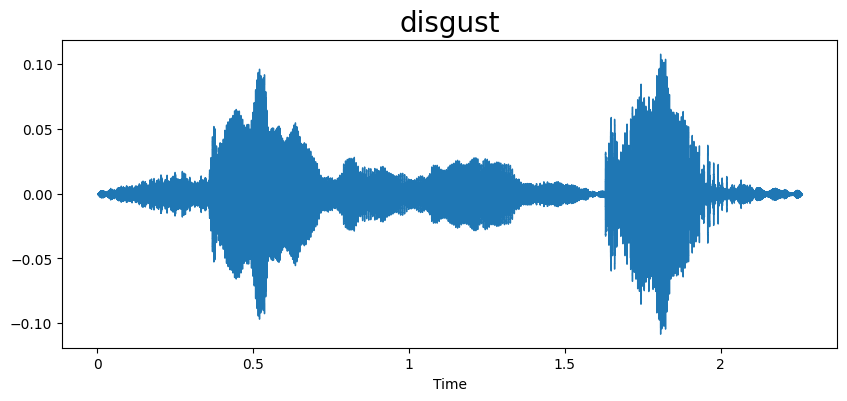

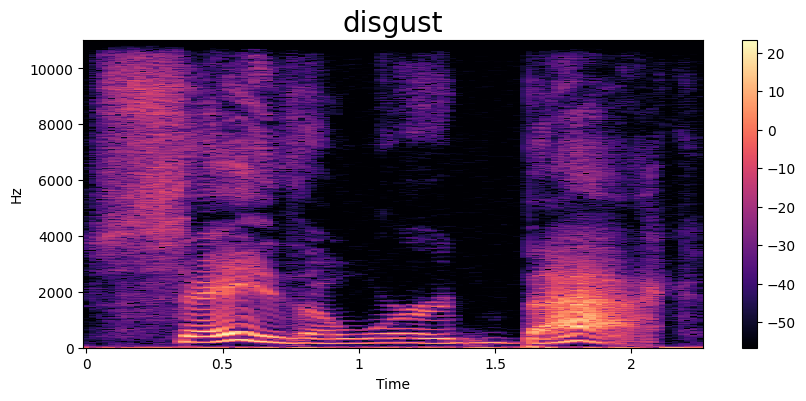

In [10]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

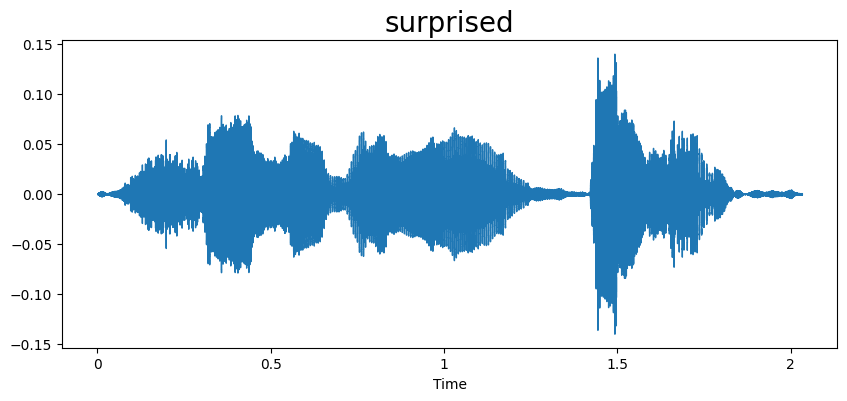

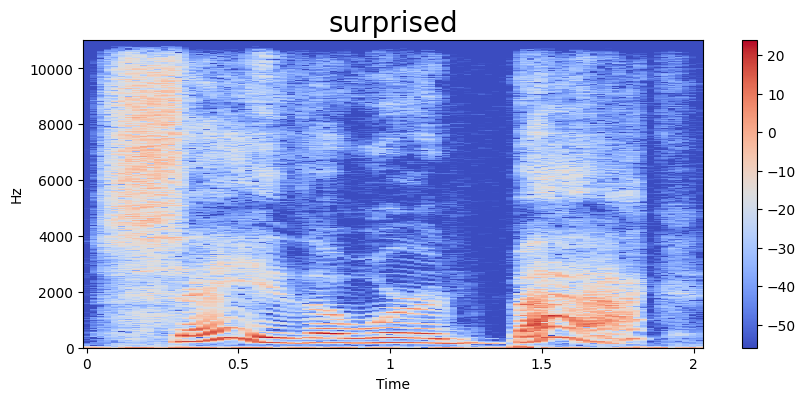

In [11]:
emotion = 'surprised'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

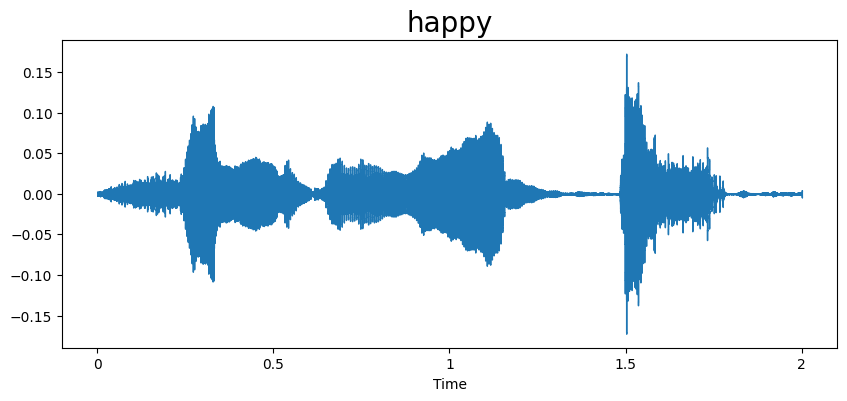

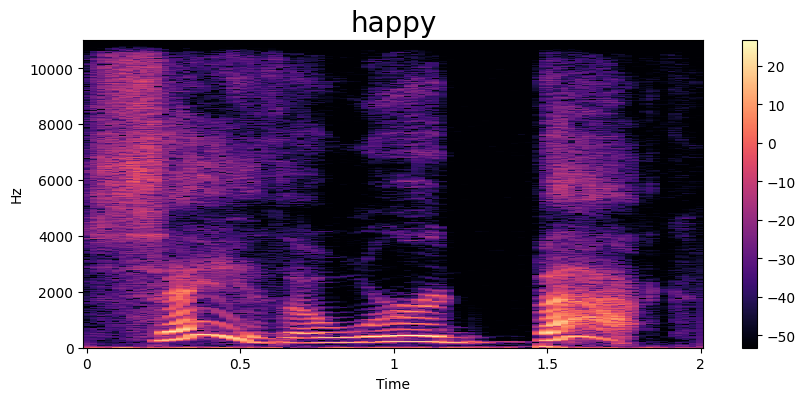

In [12]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [13]:
def extractFeatures(fileName):
    y,sr = librosa.load(fileName,duration=5,offset=0.5)
    required_features = np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)
    return required_features

In [14]:
extractFeatures(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275506e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228361e+00, -5.57365894e-01, -1.83255327e+00,  2.02101514e-01,
        7.27550924e-01,  1.31773770e+00,  2.88633752e+00,  2.85579133e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
       -7.55126286e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722492e-01,  5.11131430e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996351e+00, -1.82390726e+00,
        4.86896276e+00,  9.31392288e+00,  2.08915019e+00, -1.90649128e+00],
      dtype=float32)

In [15]:
X = df['speech'].apply(lambda x:extractFeatures(x))

In [16]:
X = [x for x in X]
X = np.array(X)
X.shape

(5600, 40)

In [17]:
X = np.expand_dims(X,-1)
X.shape

(5600, 40, 1)

In [18]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [19]:
y = y.toarray()
y.shape

(5600, 7)

In [20]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [21]:
model = Sequential()
model.add(LSTM(units=128,return_sequences=False,input_shape=(X.shape[1],1)))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=7,activation='softmax'))

In [22]:
from keras.optimizers import Adam

In [23]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,127 (301.28 KB)

 Trainable params: 77,127 (301.28 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(X, y, validation_split=0.2, epochs=200, batch_size=256, shuffle=True, verbose=True)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.2879 - loss: 1.8273 - val_accuracy: 0.3500 - val_loss: 1.5718
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5519 - loss: 1.2393 - val_accuracy: 0.6732 - val_loss: 0.8165
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6979 - loss: 0.7831 - val_accuracy: 0.9339 - val_loss: 0.3293
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8024 - loss: 0.5350 - val_accuracy: 0.9464 - val_loss: 0.2245
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8987 - loss: 0.3278 - val_accuracy: 0.9536 - val_loss: 0.1462
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9352 - loss: 0.2352 - val_accuracy: 0.9830 - val_loss: 0.0724
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9489 - loss: 0.1927 - val_accuracy: 0.9679 - val_loss: 0.0830
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9578 - loss: 0.1448 - val_accuracy: 0

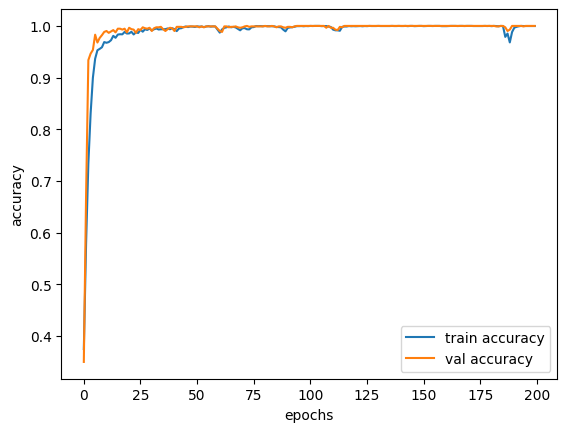

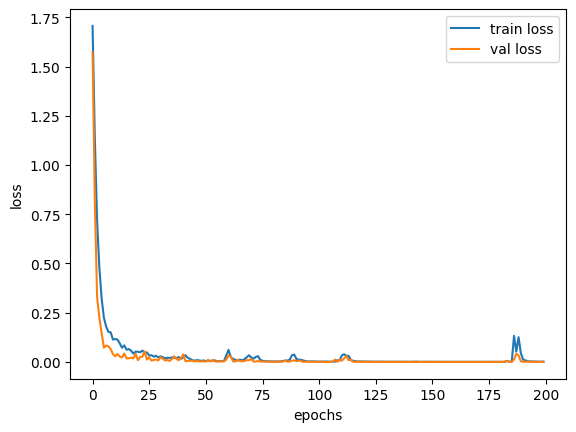

In [25]:
epochs = list(range(200))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
model.save('emotion_recognition_model.h5')